In [1]:
import tensorflow as tf
from tensorflow import keras 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

# # Data Set

In [2]:
station_day = pd.read_csv("C:/Users/rutur/OneDrive/Desktop/AQI/station_day.csv")

In [3]:
station_day.head(3)

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,NaN,NaN
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate


In [4]:
station_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108035 entries, 0 to 108034
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   StationId   108035 non-null  object 
 1   Date        108035 non-null  object 
 2   PM2.5       86410 non-null   float64
 3   PM10        65329 non-null   float64
 4   NO          90929 non-null   float64
 5   NO2         91488 non-null   float64
 6   NOx         92535 non-null   float64
 7   NH3         59930 non-null   float64
 8   CO          95037 non-null   float64
 9   SO2         82831 non-null   float64
 10  O3          82467 non-null   float64
 11  Benzene     76580 non-null   float64
 12  Toluene     69333 non-null   float64
 13  Xylene      22898 non-null   float64
 14  AQI         87025 non-null   float64
 15  AQI_Bucket  87025 non-null   object 
dtypes: float64(13), object(3)
memory usage: 13.2+ MB


# --------------------------------------- ARIMA ---------------------------------------

Arima model is a time series model . That means we can predcit how AQI change by time

In [5]:
arima_df = station_day[['Date','AQI']]

In [6]:
arima_df["Date"]= pd.to_datetime(arima_df["Date"])

In [7]:
arima_df.AQI = arima_df.groupby(pd.PeriodIndex(arima_df['Date'], freq="M"))['AQI'].apply(lambda x: x.fillna(x.mean()))

In [8]:
ts = arima_df.groupby(pd.PeriodIndex(arima_df['Date'], freq="M"))['AQI'].mean()

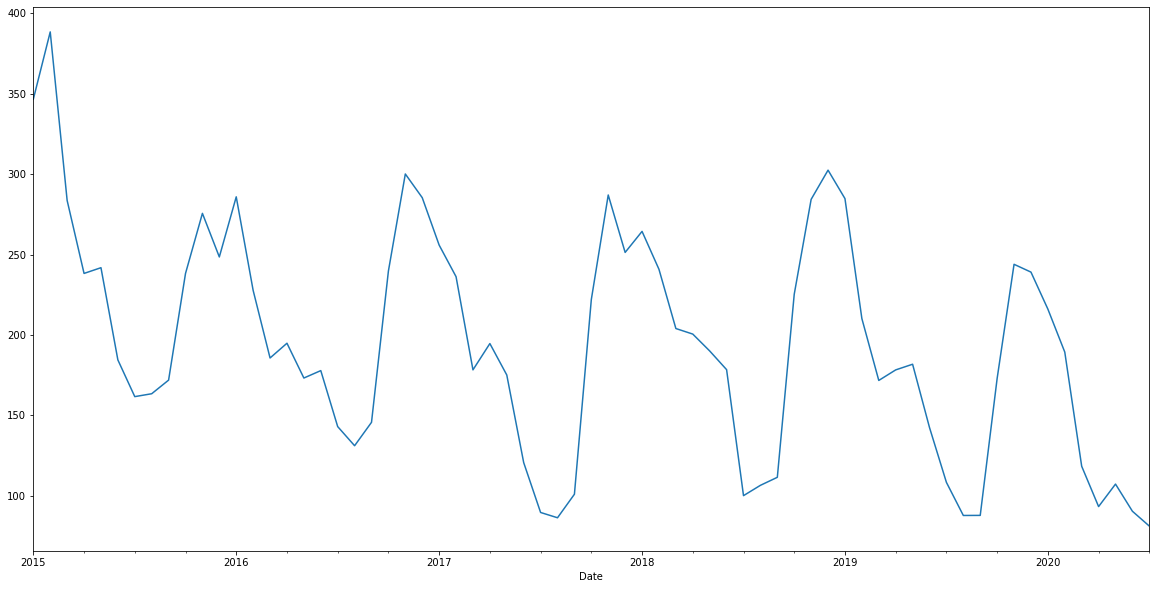

In [9]:
plt.figure(figsize = (20,10))
ts.plot()
plt.show()

**Doing adfuller test to identify the data set is stationay or not**

In [10]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.224505
p-value: 0.662967


In [11]:
ts_train = ts[:50]
ts_test = ts[50:]

In [12]:
from statsmodels.tsa.arima.model import ARIMA

In [13]:
import itertools
from sklearn.metrics import mean_squared_error

In [14]:
p = range(0,8)
q = range(0,8)
d = range(0,2)

In [15]:
pqd_combination = list(itertools.product(p,d,q))

In [16]:
error = []
pqd = []

In [17]:
for i in pqd_combination:
    A_model = ARIMA(ts_train,order= i).fit()
    predict = A_model.predict(len(ts_train),len(ts)-1)
    e = np.sqrt(mean_squared_error(ts_test,predict))
    pqd.append(i)
    error.append(e)

C:\Users\rutur\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rutur\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rutur\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rutur\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rutur\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximu

In [18]:
min = error[0]
index = 0
for i in range(1,len(error)-1):
    if(min > error[i]):
        min = error[i]
        index = i
        
print(error[index],' => ',pqd[index])

48.483828855883274  =>  (7, 1, 1)


In [19]:
model_ts = ARIMA(ts_train, order=pqd[index])
model_ts_fit = model_ts.fit()
print(model_ts_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    AQI   No. Observations:                   50
Model:                 ARIMA(7, 1, 1)   Log Likelihood                -241.966
Date:                Sat, 22 Apr 2023   AIC                            501.931
Time:                        10:58:55   BIC                            518.957
Sample:                    01-31-2015   HQIC                           508.391
                         - 02-28-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7066      0.217      3.257      0.001       0.281       1.132
ar.L2         -0.2553      0.247     -1.036      0.300      -0.739       0.228
ar.L3         -0.1310      0.188     -0.697      0.4

In [20]:
arima_predict = model_ts_fit.predict(start = len(ts_train),end = len(ts))

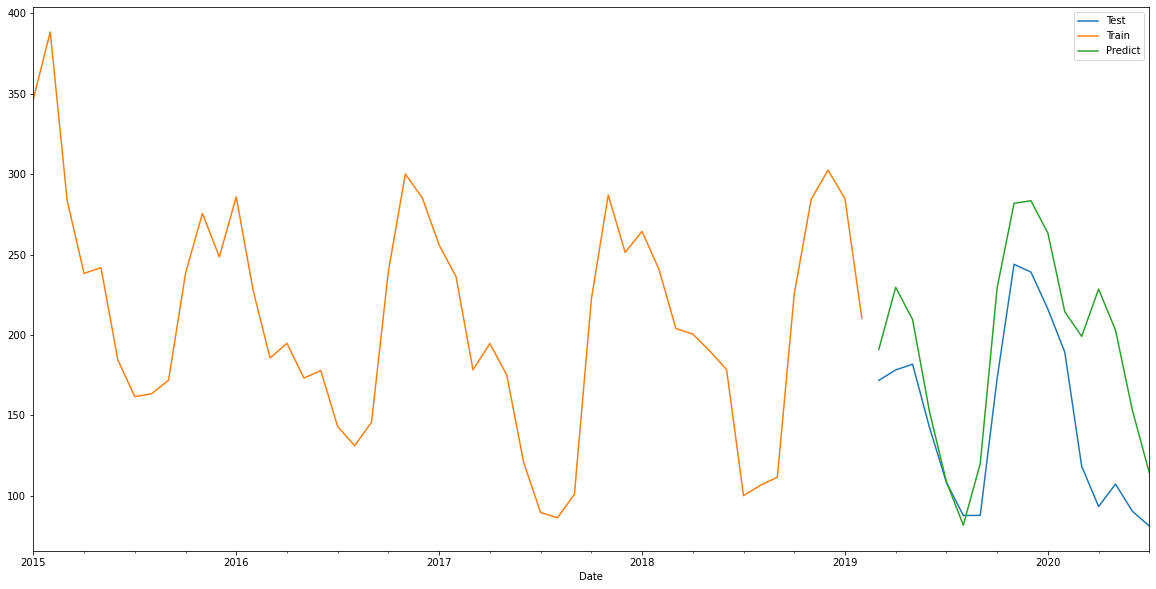

In [21]:
plt.figure(figsize = (20,10))
ts_test.plot(label = "Test")
ts_train.plot(label = "Train")
predict.plot(label = 'Predict')
plt.legend()
plt.show()

# ------------------------------- SARIM -------------------------------

In [22]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput )

Results of Dickey-Fuller Test:
Test Statistic                 -1.224505
p-value                         0.662967
#Lags Used                     10.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


*****This time series is not stationary. Because P > 0.05 .So we want to take first differntioal for series*****

In [23]:
df1_ts = ts - ts.shift(1)

In [24]:
df1_ts=df1_ts.dropna()

In [25]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df1_ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput )

Results of Dickey-Fuller Test:
Test Statistic                -7.389944e+00
p-value                        8.050075e-11
#Lags Used                     9.000000e+00
Number of Observations Used    5.600000e+01
Critical Value (1%)           -3.552928e+00
Critical Value (5%)           -2.914731e+00
Critical Value (10%)          -2.595137e+00
dtype: float64


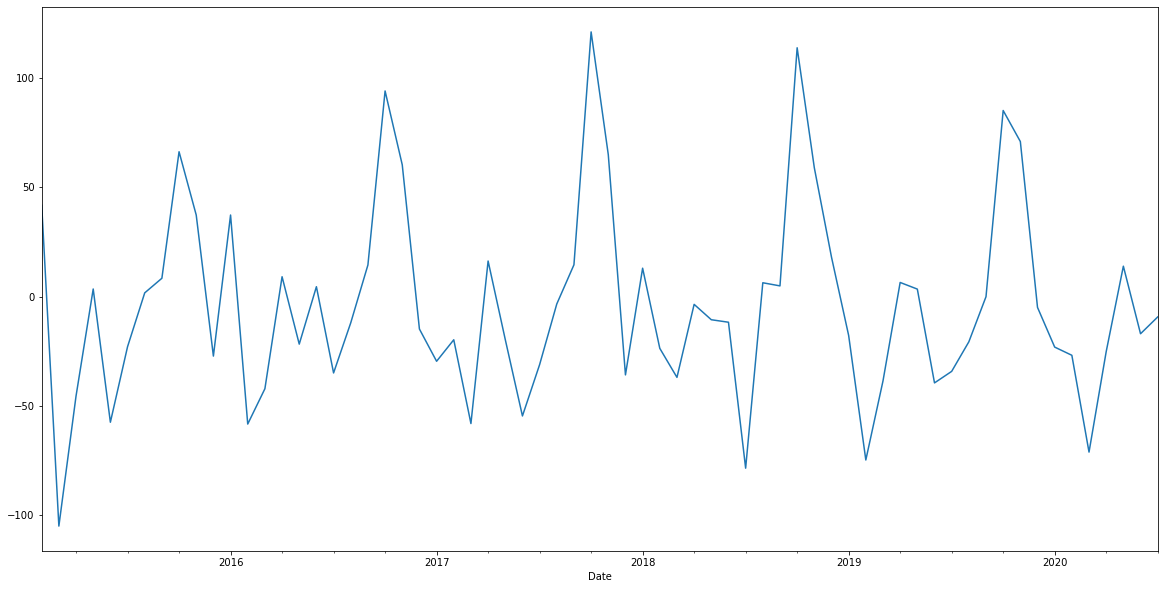

In [26]:
plt.figure(figsize = (20,10))
df1_ts.plot()
plt.show()

In [27]:
df1_ts_train = df1_ts[:50]
df1_ts_test = df1_ts[50:]

In [28]:
df_pdq = []
df_error = []

In [29]:
for i in pqd_combination:
    A_model = ARIMA(df1_ts_train,order= i).fit()
    predict = A_model.predict(len(df1_ts_train),len(df1_ts)-1)
    e = np.sqrt(mean_squared_error(df1_ts_test,predict))
    df_pdq.append(i)
    df_error.append(e)

C:\Users\rutur\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rutur\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rutur\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rutur\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rutur\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximu

In [30]:
min = df_error[0]
index = 0
for i in range(1,len(df_error)-1):
    if(min > df_error[i]):
        min = df_error[i]
        index = i
        
print(df_error[index],' => ',df_pdq[index])

20.383889653711055  =>  (7, 0, 3)


In [31]:
import statsmodels.api as sm

In [32]:
sarima_model = sm.tsa.statespace.SARIMAX(df1_ts_train, trend='n', order=(7,0,3), seasonal_order=(1,1,1,12))
s_results = sarima_model.fit()
print(s_results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  AQI   No. Observations:                   50
Model:             SARIMAX(7, 0, 3)x(1, 1, [1], 12)   Log Likelihood                -176.709
Date:                              Sat, 22 Apr 2023   AIC                            379.418
Time:                                      10:59:18   BIC                            400.706
Sample:                                  02-28-2015   HQIC                           386.992
                                       - 03-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0865      2.431      0.036      0.972      -4.678       4.851
ar.L2         -0.99

C:\Users\rutur\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [33]:
s_pred = s_results.predict(start = len(df1_ts_train),end = len(df1_ts)-1)

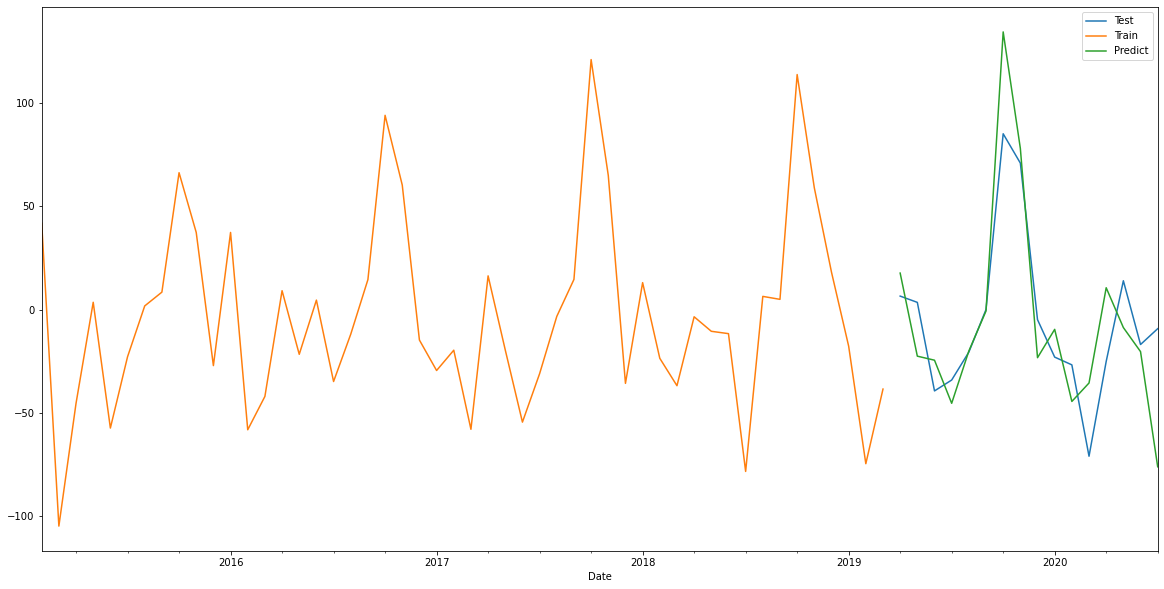

In [34]:
plt.figure(figsize = (20,10))
df1_ts_test.plot(label = "Test")
df1_ts_train.plot(label = "Train")
s_pred.plot(label = 'Predict')
plt.legend()
plt.show()

# ------------------------------------- FB Prophet -------------------------------------

FB prophet is using for time series forcasting . So we want to use date column and AQI bucket column only

In [36]:
!pip install prophet
from prophet import Prophet


  Using cached numpy-1.24.2-cp39-cp39-win_amd64.whl (14.9 MB)
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732051 sha256=2531dd34ee02dea14d9fbe023560f07797e12004594a13ef67af26d5a5edd562
  Stored in directory: c:\users\rutur\appdata\local\pip\cache\wheels\04\1f\e5\8dd0c661cd8d252817655dc14a84f7ae045d6616594145aa81
Successfully built pymeeus
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
scipy 1.7.1 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.2 which is incompatible.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.24.2 which is incompatible.
en-core-web-sm 3.5.0 requires spacy<3.6.0,>=3.5.0, but you have spacy 2.3.9 which is incompatible.


TypeError: 'numpy._DTypeMeta' object is not subscriptable

In [ ]:
!pip install --upgrade plotly

In [ ]:
alt_fb_df = station_day[['Date','AQI']]

In [ ]:
alt_fb_df["Date"]= pd.to_datetime(alt_fb_df["Date"])

In [ ]:
alt_fb_df.AQI = alt_fb_df.groupby(pd.PeriodIndex(alt_fb_df['Date'], freq="M"))['AQI'].apply(lambda x: x.fillna(x.mean()))

In [ ]:
alt_fb_df = alt_fb_df.rename(columns={'Date':'ds','AQI':'y'})

In [ ]:
alt_fb_df_train = alt_fb_df[:-26108]
alt_fb_df_test = alt_fb_df[len(alt_fb_df)-26108:]

In [ ]:
alt_fbp = Prophet(daily_seasonality = True)
alt_fbp.fit(alt_fb_df_train)



In [ ]:
alt_future = alt_fbp.make_future_dataframe(periods=365)

In [ ]:
alt_forecast = alt_fbp.predict(alt_future)

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(alt_fb_df_train['ds'],alt_fb_df_train['y'],label = "Train")
plt.plot(alt_fb_df_test['ds'],alt_fb_df_test['y'],label = "Test")
plt.plot(alt_forecast['ds'],alt_forecast['yhat'],label = 'Predict')
plt.legend()
plt.show()


# ---------------------------------------- LSTM ----------------------------------------

In [ ]:
lstm_df = station_day

In [ ]:
lstm_df["Date"]= pd.to_datetime(lstm_df["Date"])

In [ ]:
lstm_df.drop(['AQI_Bucket', 'StationId'], axis=1, inplace=True)

In [ ]:
lstm_df=lstm_df.dropna()

In [ ]:
lstm_df.info()

In [ ]:
dates = lstm_df['Date']
lstm_df.drop('Date', axis=1,inplace=True)

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

col_names = []
for i in lstm_df.columns:
    col_names.append(i)

lstm_df[col_names] = min_max_scaler.fit_transform(lstm_df[col_names])

In [ ]:
x = lstm_df.drop(columns =['AQI'])
y = lstm_df['AQI']

In [ ]:
x.describe()

In [ ]:
dates = np.array(dates)
dates

In [ ]:
x = np.array(x)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

In [ ]:
y = np.array(y)
y = y.reshape(-1,)

In [ ]:
dates_train, x_train, y_train = dates[:1500], x[:1500], y[:1500]
dates_test, x_test, y_test = dates[1500:], x[1500:], y[1500:]

In [ ]:
x_train.shape

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import InputLayer

model_lstm = Sequential()

model_lstm.add(InputLayer((12,1)))

model_lstm.add(LSTM(50))

model_lstm.add(Dense(34 ,'relu'))
# model_lstm.add(Dropout(0.25))

model_lstm.add(Dense(15 ,'relu'))

model_lstm.add(Dense(1 ,'relu' ))

In [ ]:
model_lstm.summary()

In [ ]:
model_lstm.compile(
    optimizer = 'adam',
    loss = 'mse',
    metrics = ['accuracy']
)

In [ ]:
lstm_history = model_lstm.fit(x_train,y_train,validation_split=0.33 , epochs = 10)

In [ ]:
lstm_y_pred = model_lstm.predict(x_test)

In [1]:
plt.figure(figsize = (20,10))
plt.plot(dates_train[-100:],y_train[-100:],label = "Train")
plt.plot(dates_test[:100],y_test[:100],label = "Test")
plt.plot(dates_test[:100],lstm_y_pred[:100],label = 'Predict')
plt.legend()
plt.show()


NameError: name 'plt' is not defined